In [1]:
import os
import glob
import nibabel as nb
import scipy.stats
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.mesh.array_operations import smooth_array
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
# Path to MICAPIPEsurf = mask_5k !
micapipe=os.popen("echo $MICAPIPE").read()[:-1]

# Load native mid surface
inf_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')

# Load native mid surface
inf_lh32 = read_surface(micapipe + '/surfaces/fsLR-32k.L.inflated.surf.gii', itype='gii')
inf_rh32 = read_surface(micapipe + '/surfaces/fsLR-32k.R.inflated.surf.gii', itype='gii')

# Load native pial surface
#pial_lh = read_surface(dir_FS+'/surf/lh.pial', itype='fs')
#pial_rh = read_surface(dir_FS+'/surf/rh.pial', itype='fs')

mask_lh =  nb.load(micapipe + '/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data
mask_rh =  nb.load(micapipe + '/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_5k = np.concatenate((mask_lh, mask_rh), axis=0)

# Boolean mask
mask_surf = mask_5k != 0

## Create a brain mask derived from the thickness

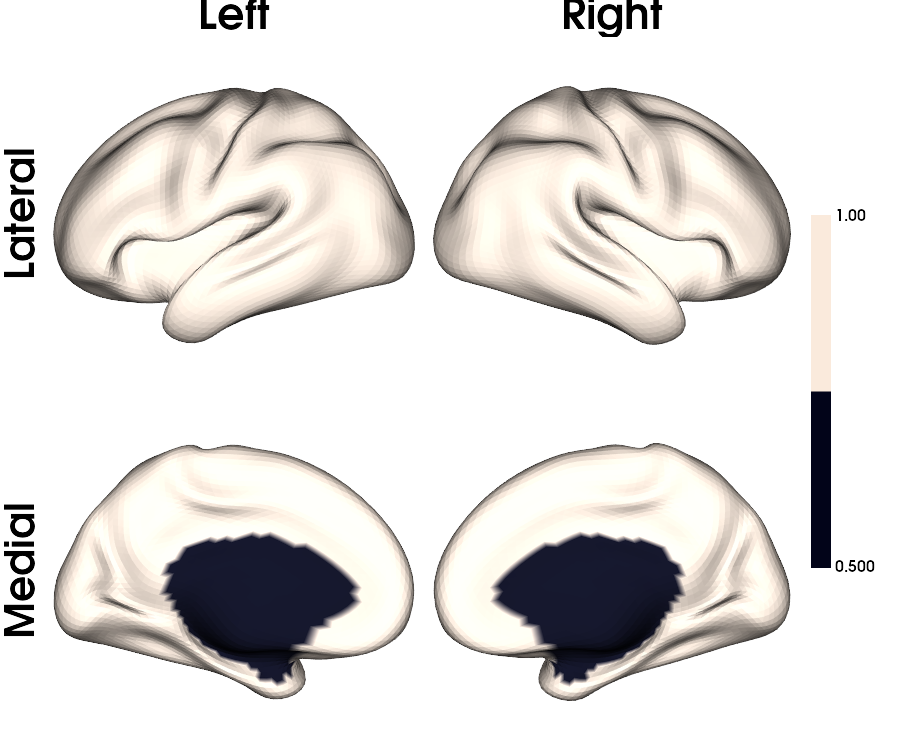

In [3]:
# Set dataset PNI as working directory
os.chdir('/data_/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0')

# Load thickness to make a better mask
lh_files = sorted(glob.glob('sub-PNC*/ses-01/maps/*_hemi-L_surf-fsLR-5k_label-thickness.func.gii'))
rh_files = sorted(glob.glob('sub-PNC*/ses-01/maps/*_hemi-R_surf-fsLR-5k_label-thickness.func.gii'))

# Load all the thickness data
Nth=np.concatenate((nb.load(lh_files[0]).darrays[0].data, nb.load(rh_files[0]).darrays[0].data), axis=0).shape[0]

surf_map=np.empty([len(lh_files), Nth], dtype=float)
for i, _ in enumerate(lh_files):
    surf_map[i,:] = np.hstack(np.concatenate((nb.load(lh_files[i]).darrays[0].data, nb.load(rh_files[i]).darrays[0].data), axis=0))
    # Mean matrix across the x axis (vertices)
    map_mean = np.mean(surf_map, axis=0)

#mask_5k = np.where(map_mean<0.3,False, True)
plot_hemispheres(inf_lh, inf_rh, array_name=mask_5k, cmap='rocket', nan_color=(0, 0, 0, 1),
                              zoom=1.3, size=(900, 750), embed_nb=True,
                              color_bar='right', layout_style='grid', color_range=(0.5,1),
                              label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']},
                              screenshot=False)

In [4]:
# load stuff
from brainspace.datasets import load_mask
mask_32k = load_mask(join=True)

inf32_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf32_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')

In [5]:
# Smooth intencities
def smooth_surf(surf_l, surf_r, points, Mask, Kernel='uniform', Niter=3, Relax=0.35):
    '''
    This function smooth an array (left and right) on a given surface
    Parameters
    ----------
    surf_l : np.array left surface 
    surf_r : np.array right surface
    points : np.array surface data
    Kernel : {'uniform', 'gaussian', 'inverse_distance'}
    Niter  : int, optional Number of smooth iterations
    Relax  : relax : float, optional relaxation factor
    Mask   : str or 1D ndarray, optional
    Returns
    -------
    sdata : smoothed numpy array
    
    '''
    Ndim = Mask.shape[0] 
    n2dim = int(Ndim/2)
    Mask_l=Mask[0:n2dim]
    Mask_r=Mask[n2dim:Ndim]
    sdata = np.concatenate((smooth_array(surf_l, points[0:n2dim],kernel=Kernel, n_iter=Niter,relax=Relax, mask=Mask_l), 
                          smooth_array(surf_r, points[n2dim:Ndim],kernel=Kernel, n_iter=Niter,relax=Relax, mask=Mask_r)), axis=0)
    return(sdata)

# Smooth each intencity
def smooth_intensities(int_profile):
    smoothed_i = np.copy(int_profile)
   
    # smooth each intensity
    for i in range(int_profile.shape[0]):
        smoothed_i[i,:] = smooth_surf(inf_lh, inf_rh, int_profile[i,:], mask_surf,Niter=5, Relax=0.5, Kernel='uniform')
   
    return(smoothed_i)

In [6]:
# Function to build the MPC from an intencity profile
def build_mpc(data, mask):
    # If no parcellation is provided, MPC will be computed vertexwise
    I = data

    # Calculate mean across columns, excluding mask and any excluded labels input
    I_M = np.nanmean(np.float32(np.where(mask, I, np.nan)), axis=1)

    # Get residuals of all columns (controlling for mean)
    I_resid = np.zeros(I.shape)
    for c in range(I.shape[1]):
        y = I[:,c]
        x = I_M
        slope, intercept, _, _, _ = scipy.stats.linregress(x,y)
        y_pred = intercept + slope*x
        I_resid[:,c] = y - y_pred

    # Calculate correlation coefficient of the intesities with residuals
    R = np.corrcoef(I_resid, rowvar=False)

    # Log transform
    MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
    MPC[np.isnan(MPC)] = 0
    MPC[np.isinf(MPC)] = 0

    # CLEANUP: correct diagonal and round values to reduce file size
    # Replace all values in diagonal by zeros to account for floating point error
    for i in range(0,MPC.shape[0]):
            MPC[i,i] = 0
    
    # Output MPC, microstructural profiles, and problem nodes
    return (MPC)

# Create the gradients from the MPC matrix
def mpc_dm(MPC, mpc_mask, Ngrad=3, Smooth=False, kernel=None):
    # Cleanup before diffusion embeding
    MPC[~np.isfinite(MPC)] = 0
    MPC[np.isnan(MPC)] = 0
    MPC[MPC==0] = np.finfo(float).eps

    # Get the index of the non medial wall regions
    indx = np.where(mpc_mask==1)[0]

    # Slice the matrix
    MPC_masked = MPC[indx, :]
    MPC_masked = MPC_masked[:, indx]
    MPC_masked.shape

    # Calculate the gradients
    MPCgm = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel=kernel)
    MPCgm.fit(MPC_masked, sparsity=0.9)
    
    # Map gradients to surface
    grad = [None] * Ngrad
    for i, g in enumerate(MPCgm.gradients_.T[0:Ngrad,:]):
        # create a new array filled with NaN values
        g_nan = np.full(mask_surf.shape, np.nan)
        g_nan[indx] = g

        # fill in the calculated values into the corresponding indices of the new array
        if Smooth==True:
            grad[i] = smooth_surf(inf_lh, inf_rh, g_nan, mask_surf,Niter=3, Relax=0.35, Kernel='uniform')
        else:
            grad[i] = g_nan
    
    return(MPCgm, grad)

def map_to_labels5k(mpc_sliced, mask):
    # Get the index of the non medial wall regions
    mask_indx = np.where(mask==1)[0]
    # map to the labels
    labels_5k = np.full(mask.shape, np.nan)
    labels_5k[mask_indx] = mpc_sliced
    return(labels_5k)

    
# Load files
def make_mpc5k(files):
    # Load all the matrices
    Ndim=9684
    M=np.empty([Ndim, Ndim, len(files)], dtype=float)
    for i, f in enumerate(files):
        print(f)
        int_profile = nb.load(f).darrays[0].data
        M[:,:,i] = build_mpc(smooth_intensities(int_profile), mask_surf)
        #M[:,:,i] = build_mpc(int_profile, mask_surf)

    return M

In [7]:
# Set the working directory to the 'out' directory
out='/data_/mica3/BIDS_PNI/derivatives'  # <<<<<<<<<<<< CHANGE THIS PATH
os.chdir(f'{out}/micapipe_v0.2.0')

Ngrad=3
Nplot = 3
# Labels for plotting based on Nplot
labels=['G'+str(x) for x in list(range(1,Nplot+1))]

## FC - resting state

In [9]:
# -----------------------------------------------------------------------------
# All subjects
acq='T1map'
# Functional connectivity files
rsfile_names = ["03", "06", "07", "09", "10", "15", "16", "18", "19", "22"]
rsfile_paths = [f"sub-PNC0{name}/ses-03/func/desc-me_task-rest_bold/surf/sub-PNC0{name}_ses-03_surf-fsLR-5k_desc-FC.shape.gii" for name in rsfile_names]

rsfiles_all = []
for rsfile_path in rsfile_paths:
    rsfiles_all.extend(glob.glob(rsfile_path))
    
# Load intensity profiles from each file
    rsprofiles = []
    for rsfile_path in rsfiles_all:
        rsprofile_data = nb.load(rsfile_path).darrays[0].data
        rsprofiles.append(rsprofile_data)
    
    rsprofiles = np.array(rsprofiles)
    mean_rsprofiles = np.mean(rsprofiles, axis=0)

In [11]:
FCz = np.arctanh(mean_rsprofiles)
FCz[~np.isfinite(FCz)] = 0
FCz = np.triu(FCz,1)+FCz.T

/tmp/ipykernel_2563393/1821604365.py:1: RuntimeWarning: divide by zero encountered in arctanh
  FCz = np.arctanh(mean_rsprofiles)


In [12]:
# Calculate the gradients
Ngrad=5
rsMPC_all, rsgrad = mpc_dm(FCz, mask_5k, Ngrad=Ngrad, Smooth=False, kernel="cosine")

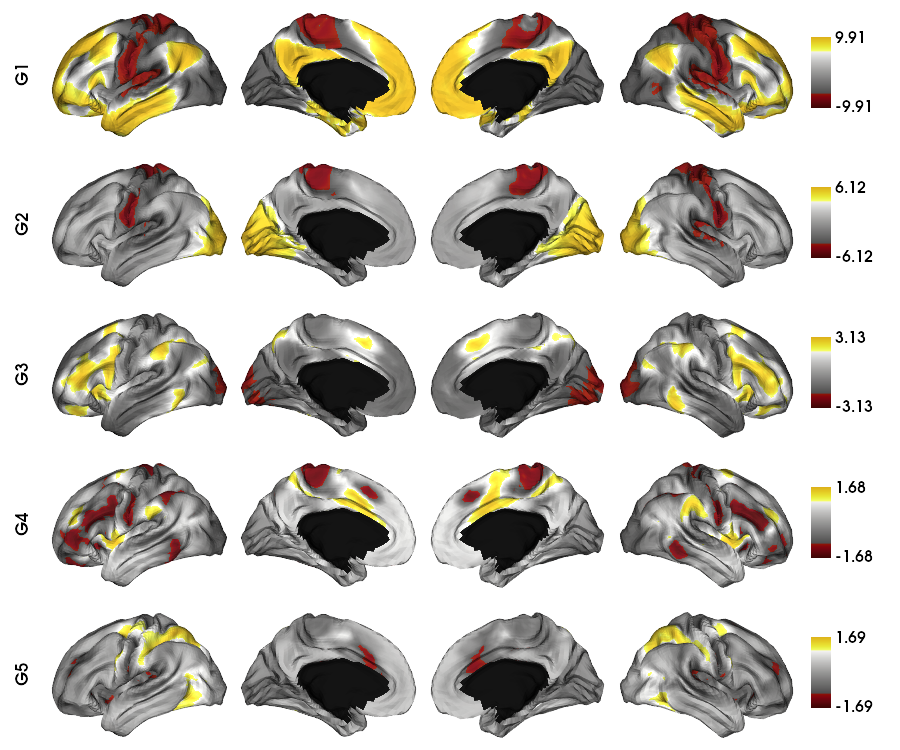

In [13]:
import cmocean
# Load fsLR 5k
f5k_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.surf.gii', itype='gii')
f5k_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.surf.gii', itype='gii')

# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(f5k_lh, f5k_rh, array_name=rsgrad, cmap='cmo.oxy', nan_color=(0, 0, 0, 1),
  zoom=1.5, size=(900, 750), embed_nb=True, color_range='sym',
  color_bar='right', label_text={'left': labels}, screenshot=False)

## FC - Episodic encoding

In [49]:
# -----------------------------------------------------------------------------
# All subjects
acq='T1map'
# Functional connectivity files
epienfile_names = ["03", "06", "07", "09", "10", "15", "16", "18", "19", "22"]
epienfile_paths = [f"sub-PNC0{name}/ses-01/func/desc-me_task-epiencode_bold/surf/sub-PNC0{name}_ses-01_surf-fsLR-5k_desc-FC.shape.gii" for name in epienfile_names]

epienfiles_all = []
for epienfile_path in epienfile_paths:
    epienfiles_all.extend(glob.glob(epienfile_path))
    
# Load intensity profiles from each file
    epienprofiles = []
    for epienfile_path in epienfiles_all:
        epienprofile_data = nb.load(epienfile_path).darrays[0].data
        epienprofiles.append(epienprofile_data)
    
    epienprofiles = np.array(epienprofiles)
    mean_epienprofiles = np.mean(epienprofiles, axis=0)

In [50]:
# Calculate the gradients
Ngrad=5
epienMPC_all, epiengrad = mpc_dm(mean_epienprofiles, mask_5k, Ngrad=Ngrad, Smooth=False, kernel="cosine")

/data/mica1/03_projects/youngeun/venv/lib/python3.8/site-packages/brainspace-0.1.10-py3.8.egg/brainspace/gradient/embedding.py:77: UserWarning: Graph is not fully connected.
  warnings.warn('Graph is not fully connected.')


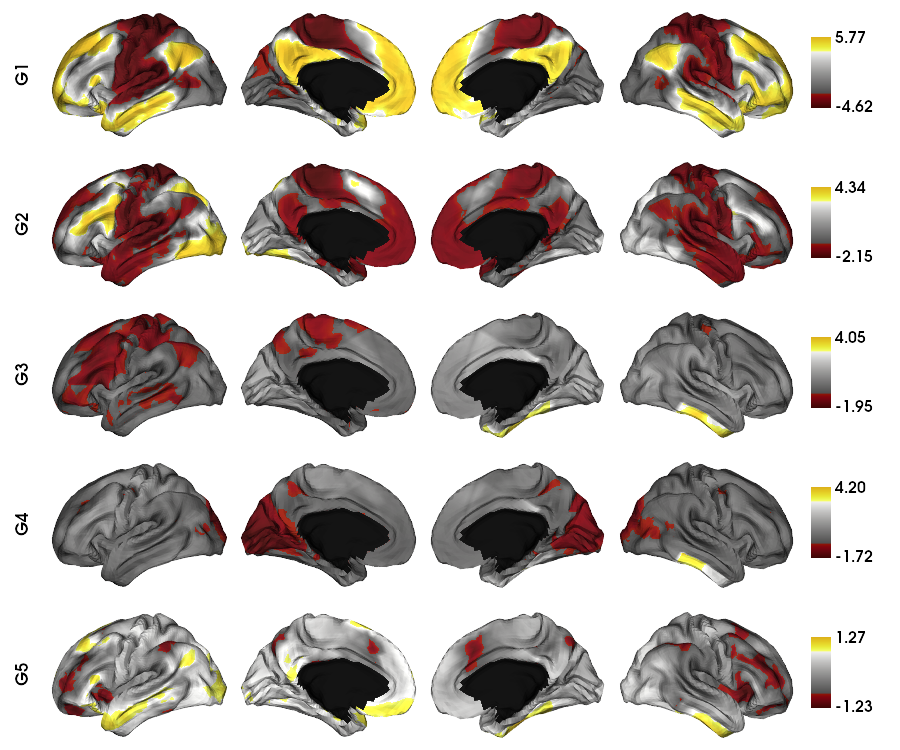

In [74]:
# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(f5k_lh, f5k_rh, array_name=epiengrad, cmap='cmo.oxy', nan_color=(0, 0, 0, 1),
  zoom=1.5, size=(900, 750), embed_nb=True,
  color_bar='right', label_text={'left': labels}, screenshot=False)

## FC - Episodic retrival

In [165]:
# -----------------------------------------------------------------------------
# All subjects
acq='T1map'
# Functional connectivity files
epirefile_names = ["03", "06", "07", "09", "10", "15", "16", "18", "19", "22"]
epirefile_paths = [f"sub-PNC0{name}/ses-01/func/desc-me_task-epiretrieve_bold/surf/sub-PNC0{name}_ses-01_surf-fsLR-5k_desc-FC.shape.gii" for name in epirefile_names]

epirefiles_all = []
for epirefile_path in epirefile_paths:
    epirefiles_all.extend(glob.glob(epirefile_path))
    
# Load intensity profiles from each file
    epireprofiles = []
    for epirefile_path in epirefiles_all:
        epireprofile_data = nb.load(epirefile_path).darrays[0].data
        epireprofiles.append(epireprofile_data)
    
    epireprofiles = np.array(epireprofiles)
    mean_epireprofiles = np.mean(epireprofiles, axis=0)

In [166]:
# Calculate the gradients
Ngrad=5
epireMPC_all, epiregrad = mpc_dm(mean_epireprofiles, mask_5k, Ngrad=Ngrad, Smooth=False, kernel="cosine")

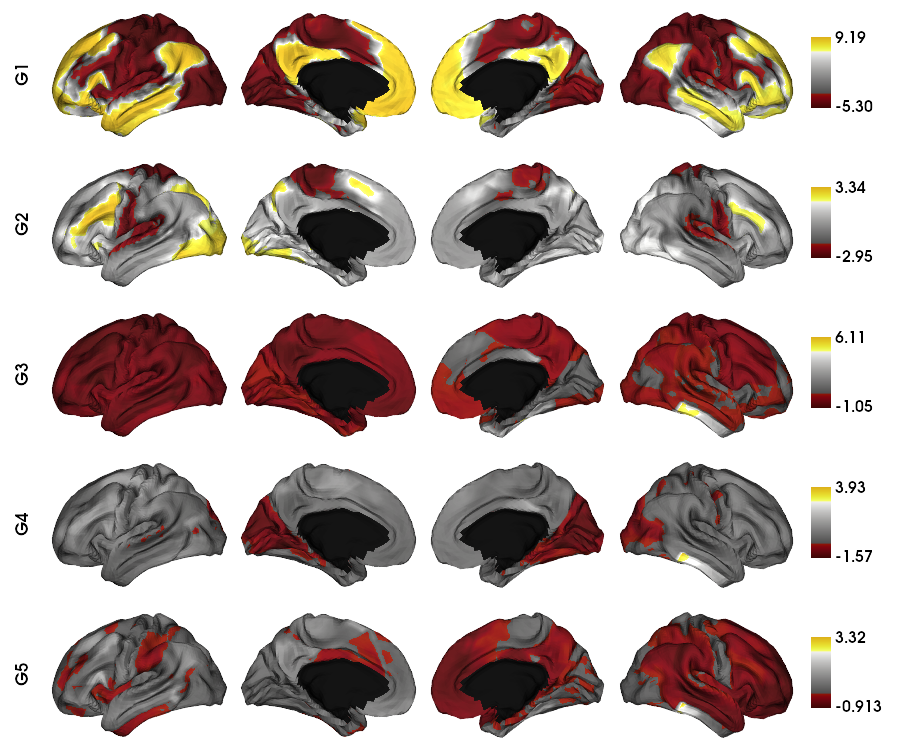

In [167]:
# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(f5k_lh, f5k_rh, array_name=epiregrad, cmap='cmo.oxy', nan_color=(0, 0, 0, 1),
  zoom=1.5, size=(900, 750), embed_nb=True,
  color_bar='right', label_text={'left': labels}, screenshot=False)

## FC - Episodic (both)

In [15]:
# -----------------------------------------------------------------------------
# All subjects
acq='T1map'
# Functional connectivity files
epifile_names = ["03", "06", "07", "09", "10", "15", "16", "18", "19", "22"]
epifile_paths = [f"sub-PNC0{name}/ses-01/func/desc-me_task-epi*_bold/surf/sub-PNC0{name}_ses-01_surf-fsLR-5k_desc-FC.shape.gii" for name in epifile_names]

epifiles_all = []
for epifile_path in epifile_paths:
    epifiles_all.extend(glob.glob(epifile_path))
    
# Load intensity profiles from each file
    epiprofiles = []
    for epifile_path in epifiles_all:
        epiprofile_data = nb.load(epifile_path).darrays[0].data
        epiprofiles.append(epiprofile_data)
    
    epiprofiles = np.array(epiprofiles)
    mean_epiprofiles = np.mean(epiprofiles, axis=0)

In [16]:
# Calculate the gradients
Ngrad=5
epiMPC_all, epigrad = mpc_dm(mean_epiprofiles, mask_5k, Ngrad=Ngrad, Smooth=False, kernel="cosine")

/data/mica1/03_projects/youngeun/venv/lib/python3.8/site-packages/brainspace-0.1.10-py3.8.egg/brainspace/gradient/embedding.py:77: UserWarning: Graph is not fully connected.
  warnings.warn('Graph is not fully connected.')


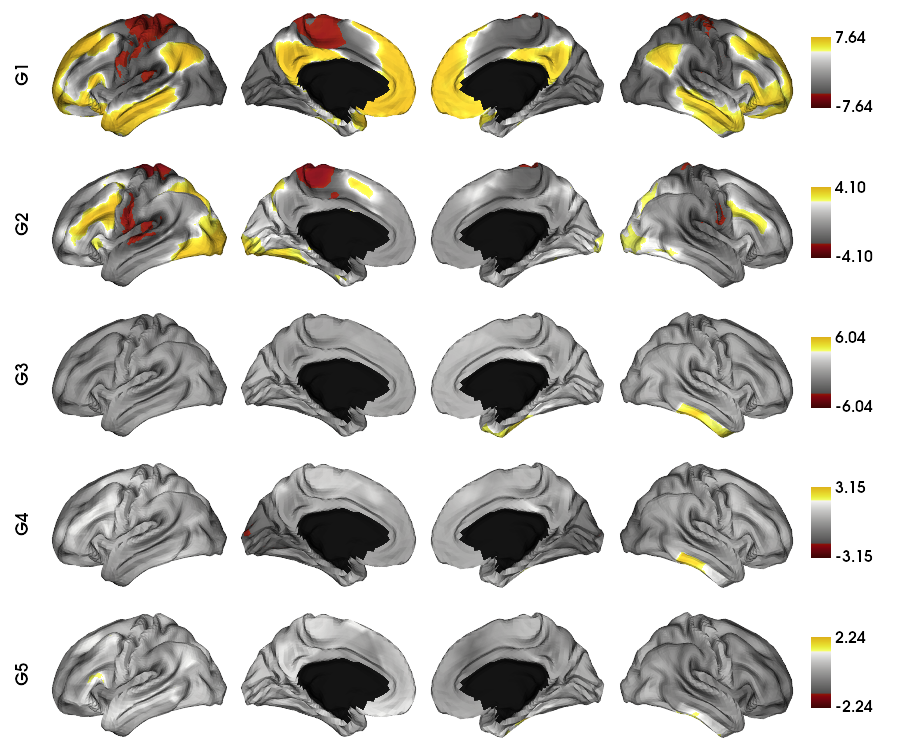

In [17]:
# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(f5k_lh, f5k_rh, array_name=epigrad, cmap='cmo.oxy', nan_color=(0, 0, 0, 1),
  zoom=1.5, size=(900, 750), embed_nb=True, color_range='sym',
  color_bar='right', label_text={'left': labels}, screenshot=False)

## FC - Semantic retrival

In [57]:
# -----------------------------------------------------------------------------
# All subjects
acq='T1map'
# Functional connectivity files
semanrefile_names = ["03", "06", "07", "09", "10", "15", "16", "18", "19", "22"]
semanrefile_paths = [f"sub-PNC0{name}/ses-02/func/desc-me_task-semantic2_bold/surf/sub-PNC0{name}_ses-02_surf-fsLR-5k_desc-FC.shape.gii" for name in semanrefile_names]

semanrefiles_all = []
for semanrefile_path in semanrefile_paths:
    semanrefiles_all.extend(glob.glob(semanrefile_path))
    
# Load intensity profiles from each file
    semanreprofiles = []
    for semanrefile_path in semanrefiles_all:
        semanreprofile_data = nb.load(semanrefile_path).darrays[0].data
        semanreprofiles.append(semanreprofile_data)
    
    semanreprofiles = np.array(semanreprofiles)
    mean_semanreprofiles = np.mean(semanreprofiles, axis=0)

In [68]:
# Calculate the gradients
Ngrad=5
semanreMPC_all, semanregrad = mpc_dm(mean_semanreprofiles, mask_5k, Ngrad=Ngrad, Smooth=False, kernel="cosine")

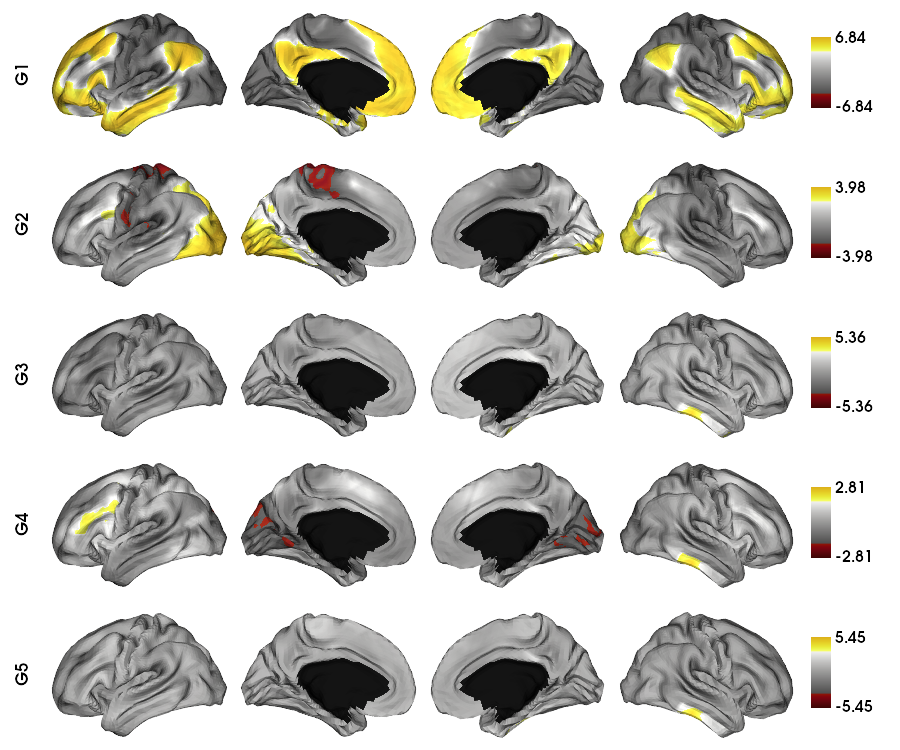

In [201]:
# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(f5k_lh, f5k_rh, array_name=semanregrad, cmap='cmo.oxy', nan_color=(0, 0, 0, 1),
  zoom=1.5, size=(900, 750), embed_nb=True, color_range='sym',
  color_bar='right', label_text={'left': labels}, screenshot=False)

## FC - Semantic (both)

In [18]:
# -----------------------------------------------------------------------------
# All subjects
acq='T1map'
# Functional connectivity files
semanfile_names = ["03", "06", "07", "09", "10", "15", "16", "18", "19", "22"]
semanfile_paths = [f"sub-PNC0{name}/ses-02/func/desc-me_task-semantic*_bold/surf/sub-PNC0{name}_ses-02_surf-fsLR-5k_desc-FC.shape.gii" for name in semanfile_names]

semanfiles_all = []
for semanfile_path in semanfile_paths:
    semanfiles_all.extend(glob.glob(semanfile_path))
    
# Load intensity profiles from each file
    semanprofiles = []
    for semanfile_path in semanfiles_all:
        semanprofile_data = nb.load(semanfile_path).darrays[0].data
        semanprofiles.append(semanprofile_data)
    
    semanprofiles = np.array(semanprofiles)
    mean_semanprofiles = np.mean(semanprofiles, axis=0)

In [19]:
# Calculate the gradients
Ngrad=5
semanMPC_all, semangrad = mpc_dm(mean_semanprofiles, mask_5k, Ngrad=Ngrad, Smooth=False, kernel="cosine")

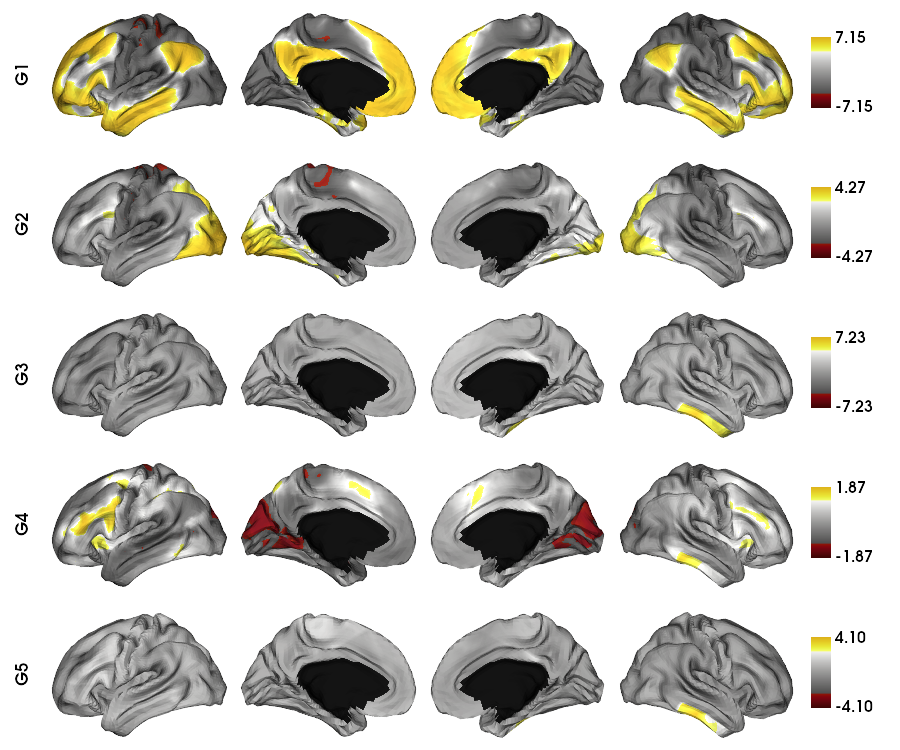

In [20]:
# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(f5k_lh, f5k_rh, array_name=semangrad, cmap='cmo.oxy', nan_color=(0, 0, 0, 1),
  zoom=1.5, size=(900, 750), embed_nb=True, color_range='sym',
  color_bar='right', label_text={'left': labels}, screenshot=False)

## FC - Movie encoding/retrival

In [21]:
# -----------------------------------------------------------------------------
# All subjects
acq='T1map'
# Functional connectivity files
mvfile_names = ["03", "06", "07", "09", "10", "15", "16", "18", "19", "22"]
mvfile_paths = [f"sub-PNC0{name}/ses-04/func/desc-me_task-audiobook*_bold/surf/sub-PNC0{name}_ses-04_surf-fsLR-5k_desc-FC.shape.gii" for name in mvfile_names]

mvfiles_all = []
for mvfile_path in mvfile_paths:
    mvfiles_all.extend(glob.glob(mvfile_path))
    
# Load intensity profiles from each file
    mvprofiles = []
    for mvfile_path in mvfiles_all:
        mvprofile_data = nb.load(mvfile_path).darrays[0].data
        mvprofiles.append(mvprofile_data)
    
    mvprofiles = np.array(mvprofiles)
    mean_mvprofiles = np.mean(mvprofiles, axis=0)

In [22]:
# Calculate the gradients
Ngrad=5
mvMPC_all, mvgrad = mpc_dm(mean_mvprofiles, mask_5k, Ngrad=Ngrad, Smooth=False, kernel="cosine")

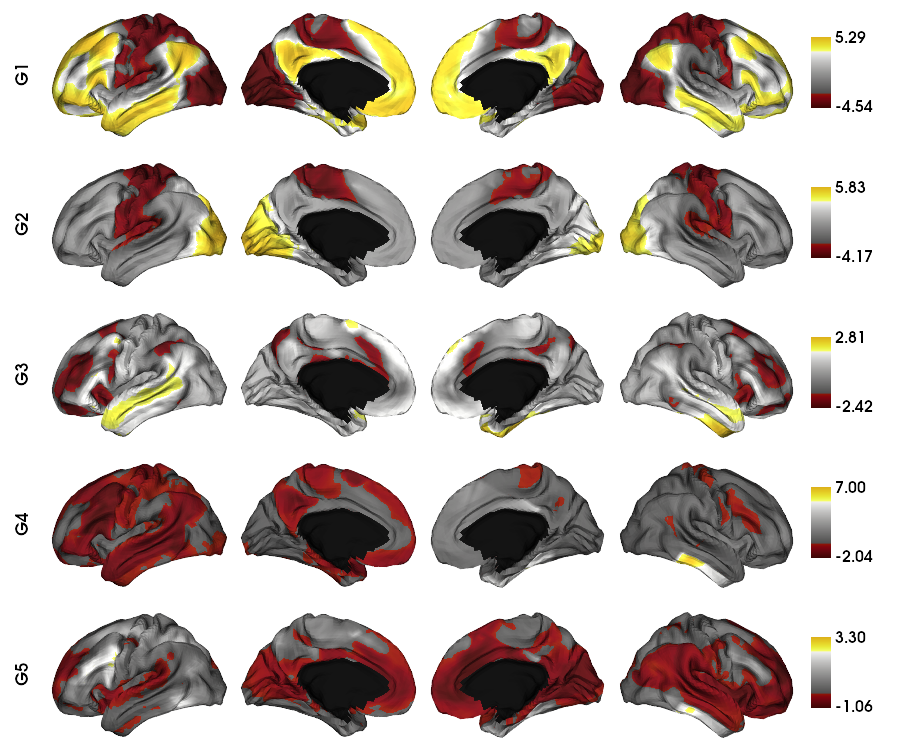

In [23]:
# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(f5k_lh, f5k_rh, array_name=mvgrad, cmap='cmo.oxy', nan_color=(0, 0, 0, 1),
  zoom=1.5, size=(900, 750), embed_nb=True,
  color_bar='right', label_text={'left': labels}, screenshot=False)

## FC - Pattern (both)

In [24]:
# -----------------------------------------------------------------------------
# All subjects
acq='T1map'
# Functional connectivity files
sepfile_names = ["03", "06", "07", "09", "10", "15", "16", "18", "19", "22"]
sepfile_paths = [f"sub-PNC0{name}/ses-01/func/desc-me_task-pattern*_bold/surf/sub-PNC0{name}_ses-01_surf-fsLR-5k_desc-FC.shape.gii" for name in sepfile_names]

sepfiles_all = []
for sepfile_path in sepfile_paths:
    sepfiles_all.extend(glob.glob(sepfile_path))
    
# Load intensity profiles from each file
    sepprofiles = []
    for sepfile_path in sepfiles_all:
        sepprofile_data = nb.load(sepfile_path).darrays[0].data
        sepprofiles.append(sepprofile_data)
    
    sepprofiles = np.array(sepprofiles)
    mean_sepprofiles = np.mean(sepprofiles, axis=0)

In [25]:
# Calculate the gradients
Ngrad=5
sepMPC_all, sepgrad = mpc_dm(mean_sepprofiles, mask_5k, Ngrad=Ngrad, Smooth=False, kernel="cosine")

/data/mica1/03_projects/youngeun/venv/lib/python3.8/site-packages/brainspace-0.1.10-py3.8.egg/brainspace/gradient/embedding.py:77: UserWarning: Graph is not fully connected.
  warnings.warn('Graph is not fully connected.')


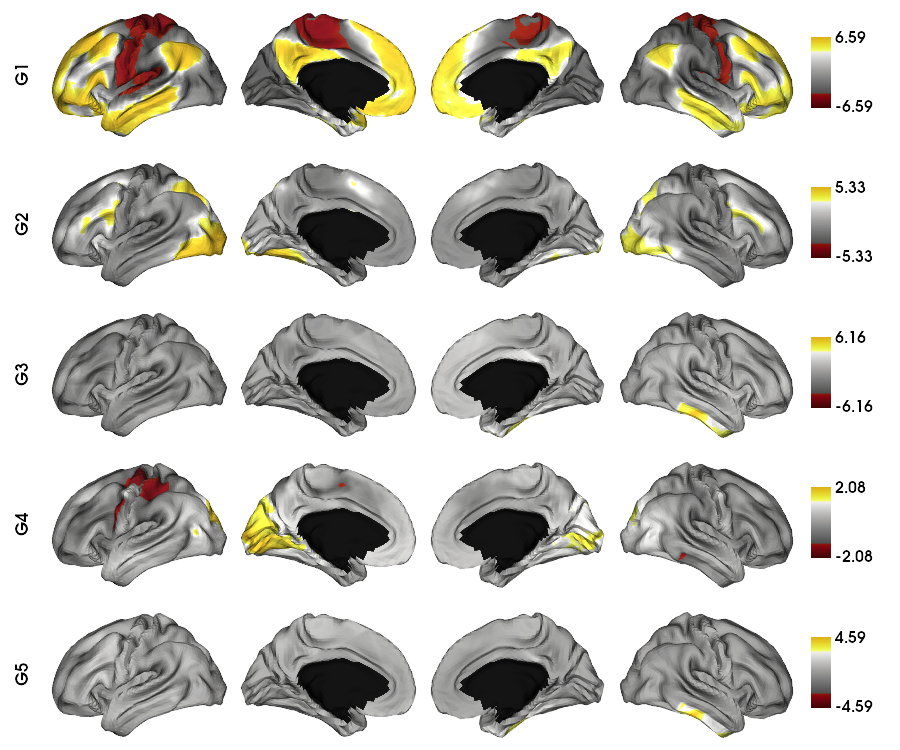

In [26]:
# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(f5k_lh, f5k_rh, array_name=sepgrad, cmap='cmo.oxy', nan_color=(0, 0, 0, 1),
  zoom=1.5, size=(900, 750), embed_nb=True, color_range='sym',
  color_bar='right', label_text={'left': labels}, screenshot=False)

## FC - Spatial (both)

In [31]:
# -----------------------------------------------------------------------------
# All subjects
acq='T1map'
# Functional connectivity files
ssfile_names = ["03", "06", "07", "09", "10", "15", "16", "18", "19", "22"]
ssfile_paths = [f"sub-PNC0{name}/ses-02/func/desc-me_task-spatial*_bold/surf/sub-PNC0{name}_ses-02_surf-fsLR-5k_desc-FC.shape.gii" for name in ssfile_names]

ssfiles_all = []
for ssfile_path in ssfile_paths:
    ssfiles_all.extend(glob.glob(ssfile_path))
    
# Load intensity profiles from each file
    ssprofiles = []
    for ssfile_path in ssfiles_all:
        ssprofile_data = nb.load(ssfile_path).darrays[0].data
        ssprofiles.append(ssprofile_data)
    
    ssprofiles = np.array(ssprofiles)
    mean_ssprofiles = np.mean(ssprofiles, axis=0)

In [32]:
# Calculate the gradients
Ngrad=5
ssMPC_all, ssgrad = mpc_dm(mean_ssprofiles, mask_5k, Ngrad=Ngrad, Smooth=False, kernel="cosine")

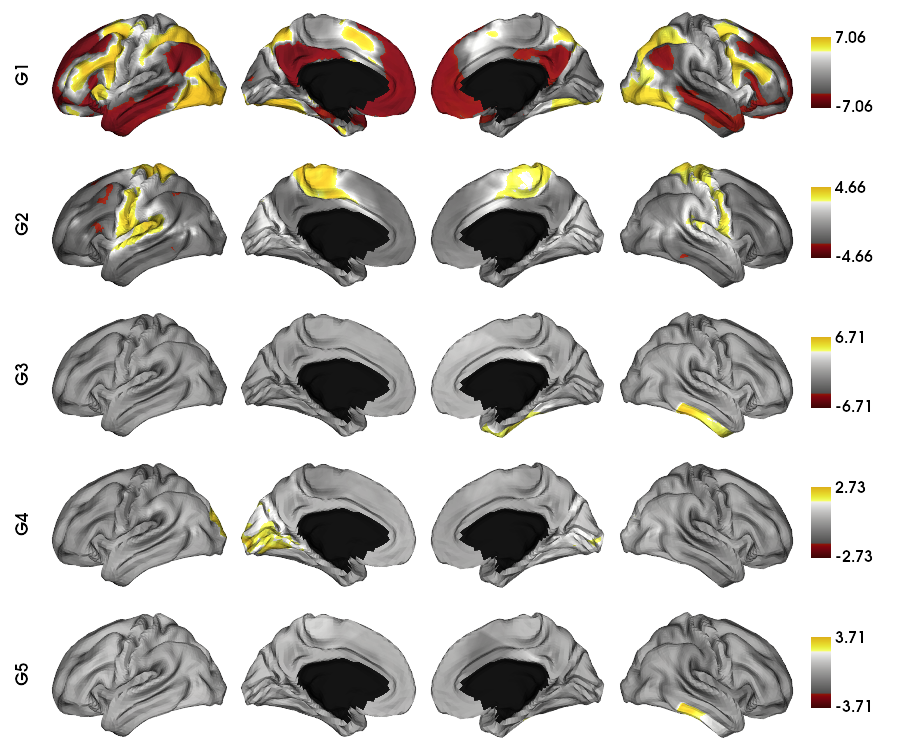

In [33]:
# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(f5k_lh, f5k_rh, array_name=ssgrad, cmap='cmo.oxy', nan_color=(0, 0, 0, 1),
  zoom=1.5, size=(900, 750), embed_nb=True, color_range='sym',
  color_bar='right', label_text={'left': labels}, screenshot=False)

## FC - Semphon (both)

In [9]:
# -----------------------------------------------------------------------------
# All subjects
acq='T1map'
# Functional connectivity files
semphonfile_names = ["03", "06", "07", "09", "10", "15", "16", "18", "19", "22"]
semphonfile_paths = [f"sub-PNC0{name}/ses-04/func/desc-me_task-semphon*_bold/surf/sub-PNC0{name}_ses-04_surf-fsLR-5k_desc-FC.shape.gii" for name in semphonfile_names]

semphonfiles_all = []
for semphonfile_path in semphonfile_paths:
    semphonfiles_all.extend(glob.glob(semphonfile_path))
    
# Load intensity profiles from each file
    semphonprofiles = []
    for semphonfile_path in semphonfiles_all:
        semphonprofile_data = nb.load(semphonfile_path).darrays[0].data
        semphonprofiles.append(semphonprofile_data)
    
    semphonprofiles = np.array(semphonprofiles)
    mean_semphonprofiles = np.mean(semphonprofiles, axis=0)

In [10]:
# Calculate the gradients
Ngrad=5
semphonMPC_all, semphongrad = mpc_dm(mean_semphonprofiles, mask_5k, Ngrad=Ngrad, Smooth=False, kernel="cosine")

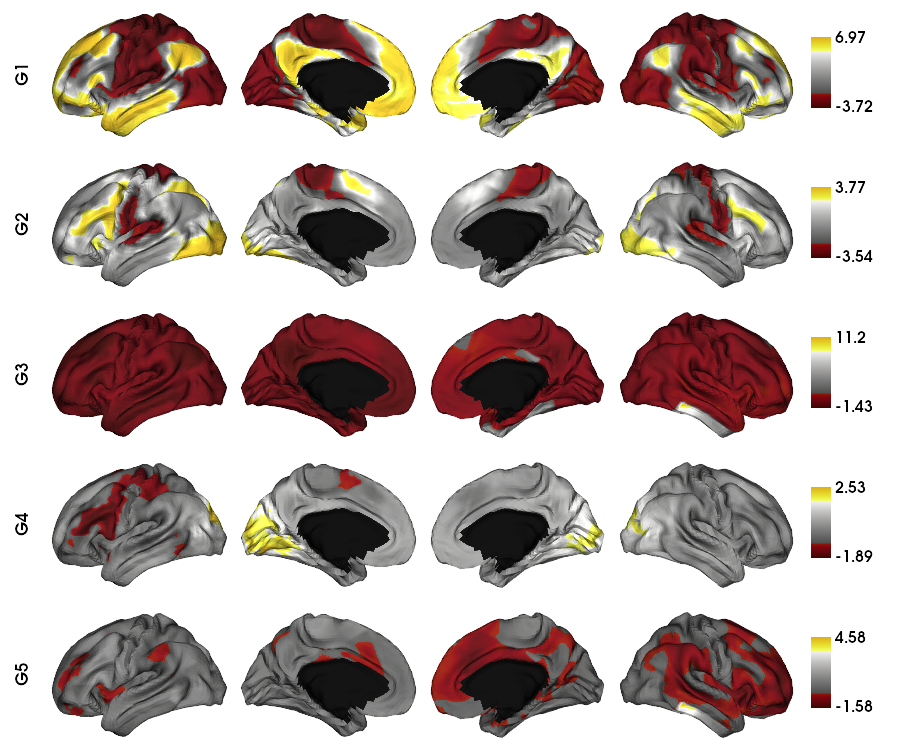

In [29]:
# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(f5k_lh, f5k_rh, array_name=semphongrad, cmap='cmo.oxy', nan_color=(0, 0, 0, 1),
  zoom=1.5, size=(900, 750), embed_nb=True,
  color_bar='right', label_text={'left': labels}, screenshot=False)

In [193]:
np.save('/host/percy/local_raid/youngeun/myjupyter/array/FC_rs_G1.npy', rsgrad[0])
np.save('/host/percy/local_raid/youngeun/myjupyter/array/FC_episodic_G1.npy', epigrad[0])
np.save('/host/percy/local_raid/youngeun/myjupyter/array/FC_pattern_G1.npy', sepgrad[0])
np.save('/host/percy/local_raid/youngeun/myjupyter/array/FC_semantic_G1.npy', semangrad[0])
np.save('/host/percy/local_raid/youngeun/myjupyter/array/FC_spatial_G1.npy', ssgrad[0])
np.save('/host/percy/local_raid/youngeun/myjupyter/array/FC_audiobook_G1.npy', mvgrad[1])
np.save('/host/percy/local_raid/youngeun/myjupyter/array/FC_semphon_G1.npy', semphongrad[0])

## Calculate the Correlation Matrix

In [17]:
T1map_SWM = np.load('/host/percy/local_raid/youngeun/myjupyter/array/T1map_SWM_G1.npy')
R1_SWM = np.load('/host/percy/local_raid/youngeun/myjupyter/array/R1_SWM.npy')
MTSAT_SWM = np.load('/host/percy/local_raid/youngeun/myjupyter/array/MTSAT_SWM.npy')
MTSATnew_SWM = np.load('/host/percy/local_raid/youngeun/myjupyter/array/MTSATnew_SWM_G1.npy')
FA_SWM = np.load('/host/percy/local_raid/youngeun/myjupyter/array/FA_SWM_G1.npy')
ODI_SWM = np.load('/host/percy/local_raid/youngeun/myjupyter/array/ODI_SWM_G1.npy')
mMPC_SWM = np.load('/host/percy/local_raid/youngeun/myjupyter/array/mMPC_G1.npy')
mMPCnew_SWM = np.load('/host/percy/local_raid/youngeun/myjupyter/array/mMPC_SWM_G1_T1map_MTSAT.npy')
BB_SWM = np.load('/host/percy/local_raid/youngeun/myjupyter/array/BB_SWM_G1.npy')
BBnew_SWM = np.load('/host/percy/local_raid/youngeun/myjupyter/array/BB_SWM_G1_noregress.npy')
BB_GM1 = np.load('/host/percy/local_raid/youngeun/myjupyter/array/BB_GM_G1.npy')
BB_GM2 = np.load('/host/percy/local_raid/youngeun/myjupyter/array/BB_GM_G2.npy')
qT1_GM = np.load('/host/percy/local_raid/youngeun/myjupyter/array/qT1_GM_G1.npy')
rs = np.load('/host/percy/local_raid/youngeun/myjupyter/array/FC_rs_G1.npy')
#epi = epigrad[0]
#epien = epiengrad[0]
#epire = epiregrad[0]
#seman = semangrad[0]
#semanre = semanregrad[0]
#spatial = ssgrad[0]
#movie = mvgrad[1]
#pattern = sepgrad[0]
#semphon = semphongrad[0]

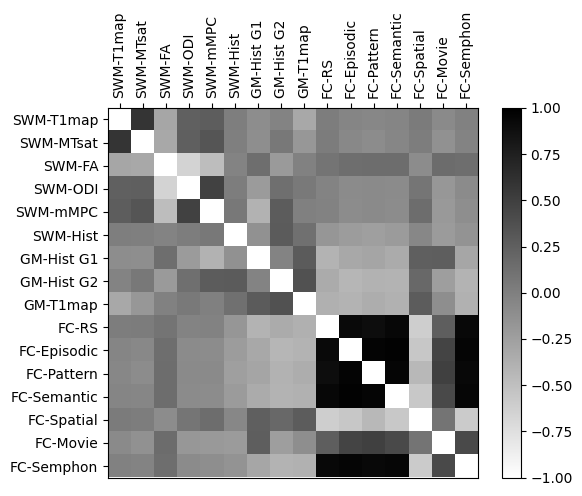

In [54]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import spearmanr
#import matplotlib as mpl

qmri_list = ['SWM-T1map', 'SWM-MTsat', 'SWM-FA', 'SWM-ODI', 'SWM-mMPC', 'SWM-Hist', 'GM-Hist G1', 'GM-Hist G2', 'GM-T1map', 'FC-RS', 'FC-Episodic', 'FC-Pattern', 'FC-Semantic', 'FC-Spatial', 'FC-Movie', 'FC-Semphon']

total_matrix = np.vstack([T1map_SWM, MTSAT_SWM, FA_SWM, ODI_SWM, mMPC_SWM, BB_SWM, BB_GM1, BB_GM2, qT1_SWM, rs, epi, pattern, seman, spatial, movie, semphon])
total_matrix[:, mask_5k == False] = np.nan

# Identify rows with NaN values and exclude them
valid_rows = ~np.isnan(total_matrix).any(axis=0)
total_matrix = total_matrix[:, valid_rows]

#correlation_matrix = np.corrcoef(total_matrix) # Calculate Pearson correlation
correlation_matrix, _ = spearmanr(total_matrix.T) # Calculate Spearman correlation 
#correlation_matrix = (correlation_matrix + 1) / 2

# Set the diagonal values to 0
np.fill_diagonal(correlation_matrix, -1)

plt.imshow(correlation_matrix, cmap='gray_r', vmin=-1, vmax=1, aspect='equal')
plt.colorbar()
plt.xticks(np.arange(len(qmri_list)), qmri_list, rotation=90)
plt.yticks(np.arange(len(qmri_list)), qmri_list, rotation=0)

mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.labeltop'] = True
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['xtick.labelbottom'] = False

mpl.rcParams['ytick.right'] = False
mpl.rcParams['ytick.labelright'] = False
mpl.rcParams['ytick.left'] = True
mpl.rcParams['ytick.labelleft'] = True

plt.show()

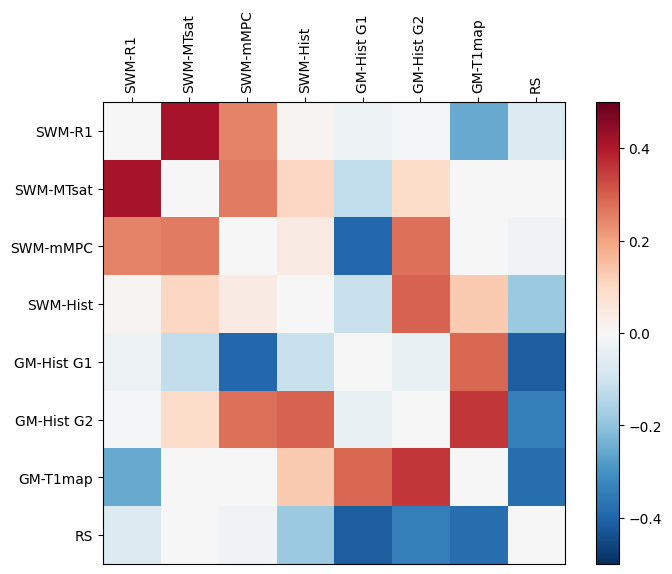

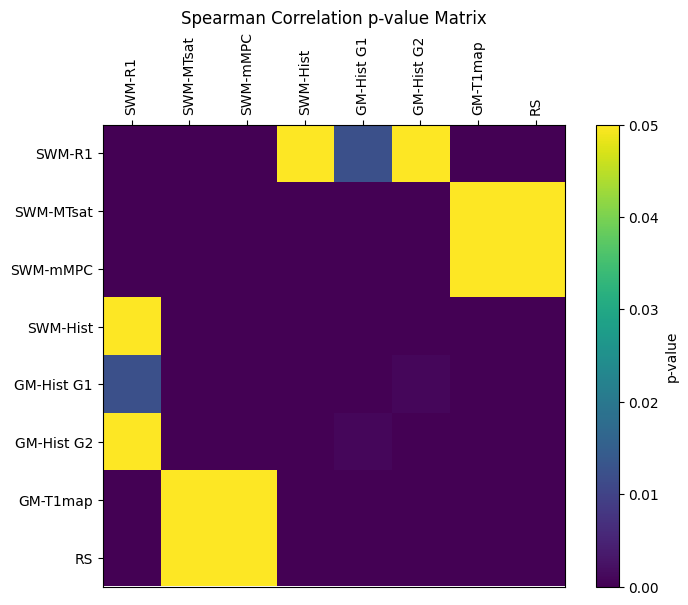

In [20]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import spearmanr
#import matplotlib as mpl

qmri_list = ['SWM-R1', 'SWM-MTsat', 'SWM-mMPC', 'SWM-Hist', 'GM-Hist G1', 'GM-Hist G2', 'GM-T1map', 'RS']

total_matrix = np.vstack([R1_SWM, MTSAT_SWM, mMPC_SWM, BBnew_SWM, BB_GM1, BB_GM2, qT1_GM, rs])
total_matrix[:, mask_5k == False] = np.nan

# Identify rows with NaN values and exclude them
valid_rows = ~np.isnan(total_matrix).any(axis=0)
total_matrix = total_matrix[:, valid_rows]

#correlation_matrix = np.corrcoef(total_matrix) # Calculate Pearson correlation
correlation_matrix, p_value_matrix = spearmanr(total_matrix.T) # Calculate Spearman correlation 
#correlation_matrix = (correlation_matrix + 1) / 2

# Set the diagonal values to 0
np.fill_diagonal(correlation_matrix, 0)

plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='RdBu_r', vmin=-0.5, vmax=0.5, aspect='equal')
plt.colorbar()
plt.xticks(np.arange(len(qmri_list)), qmri_list, rotation=90)
plt.yticks(np.arange(len(qmri_list)), qmri_list, rotation=0)

mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.labeltop'] = True
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['xtick.labelbottom'] = False

mpl.rcParams['ytick.right'] = False
mpl.rcParams['ytick.labelright'] = False
mpl.rcParams['ytick.left'] = True
mpl.rcParams['ytick.labelleft'] = True

plt.show()

# Plot p-value matrix
plt.figure(figsize=(8, 6))
plt.imshow(p_value_matrix, cmap='viridis', vmin=0, vmax=0.05, aspect='equal')
plt.colorbar(label='p-value')
plt.xticks(np.arange(len(qmri_list)), qmri_list, rotation=90)
plt.yticks(np.arange(len(qmri_list)), qmri_list)

mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.labeltop'] = True
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['xtick.labelbottom'] = False

mpl.rcParams['ytick.right'] = False
mpl.rcParams['ytick.labelright'] = False
mpl.rcParams['ytick.left'] = True
mpl.rcParams['ytick.labelleft'] = True

plt.title('Spearman Correlation p-value Matrix')
plt.show()

In [44]:
crop_matrix = correlation_matrix[:6, 6:]

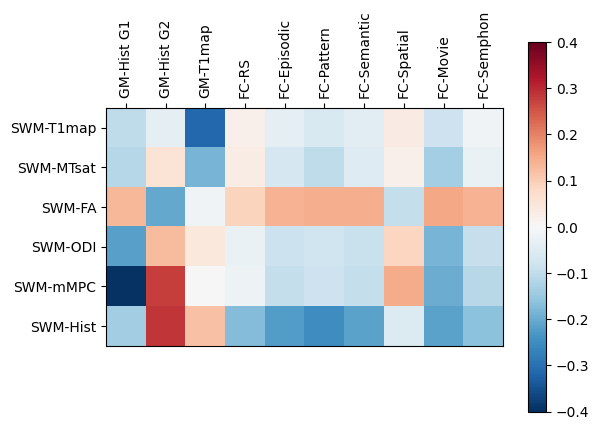

In [57]:
x_list = ['GM-Hist G1', 'GM-Hist G2', 'GM-T1map', 'FC-RS', 'FC-Episodic', 'FC-Pattern', 'FC-Semantic', 'FC-Spatial', 'FC-Movie', 'FC-Semphon']
y_list = ['SWM-T1map', 'SWM-MTsat', 'SWM-FA', 'SWM-ODI', 'SWM-mMPC', 'SWM-Hist']

plt.imshow(crop_matrix, cmap='RdBu_r', aspect='equal', vmin=-0.4, vmax=0.4,)
plt.colorbar()

plt.xticks(np.arange(len(x_list)), x_list, rotation=90)
plt.yticks(np.arange(len(y_list)), y_list, rotation=0)

mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.labeltop'] = True
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['xtick.labelbottom'] = False

mpl.rcParams['ytick.right'] = False
mpl.rcParams['ytick.labelright'] = False
mpl.rcParams['ytick.left'] = True
mpl.rcParams['ytick.labelleft'] = True

plt.show()

In [52]:
np.save('/host/percy/local_raid/youngeun/myjupyter/array/correlation_matrix.npy', correlation_matrix)
np.save('/host/percy/local_raid/youngeun/myjupyter/array/crop_matrix.npy', crop_matrix)